# Effective Training

Objectives: study how to debug backprop using numerical gradient verification, experiment with parameters initialisation and combat overfitting with regularisation.

**Instructions:** ensure your Python environment is setup with the following additional packages: 

- `t5utils.py` contains unit tests to check your code and helper functions

In [1]:
# Package imports
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import t5utils as t5

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## A. Gradient Verification ##

The backprop algorithm for training deep neural networks requires the computation of $\frac{\partial \mathcal{L}}{\partial \theta}$, the gradient of a loss function $\mathcal{L}$ with respect to all model parameters $\theta$. The loss is computed using forward propagation.

By definition the partial derivative of $\mathcal{L}$ with respect to $\mathcal{\theta}$ is:

$$ \frac{\partial \mathcal{L}}{\partial \theta} = \lim_{\varepsilon \to 0} \frac{\mathcal{L}(\theta + \varepsilon) - \mathcal{L}(\theta - \varepsilon)}{2 \varepsilon} \tag{1}$$

Assuming that our inference model implementation is correct (forward prop), we can check the gradients computation by evaluating $\mathcal{L}(\theta + \varepsilon)$ and $\mathcal{L}(\theta - \varepsilon)$ using forward prop for a small value of $\varepsilon$.

<font color='darkred'>**Exercise:**</font> Complete the gradient verification function for a simple linear model where $\theta = W$.

- Implement the linear forward propagation
- Implement the linear backprop
- Implement the gradient verification

In [2]:
# Forward propagation for linear model
def linear_fwd(W, X):
    """
    Linearity forward

    Arguments:
    W -- weights, (n_x, 1)
    X -- input (n, n_x)

    Returns:
    Y -- linear output, shape (n, 1)
    cache -- dictionary for backpropagation
        W -- weights, (n_x, 1)
        X -- linear input, (n, n_x)
    """
    
    ### INPUT YOUR CODE HERE ### (1 line)
    Y = X @ W
    ### END OF YOUR CODE SEGMENT ###  
    cache = {'W': W, 'X': X}

    return Y, cache

In [3]:
# testing
np.random.seed(2019)
Y, _ = linear_fwd(np.random.randn(2,1), np.random.randn(1,2))
print("Y = {}".format(Y))

Y = [[0.772]]


***Expected Output:***<br>
`Y = [[0.772]]`

In [4]:
# Backward propagation for linearity
def linear_back(L, cache):
    """
    Linearity backprop

    Arguments:
    L -- loss
    cache -- dictionary from forward propagation
        W -- weights, (n_x, 1)
        X -- linear input, (n, n_x)

    Returns:
    dW -- gradient of L with respect to W, (n_x, 1)
    """

    ### INPUT YOUR CODE HERE ### (3 lines)
    X = cache['X']
    n = X.shape[0]
    dW = X.T/n          #########why this
    ### END OF YOUR CODE SEGMENT ### 
        
    return dW

In [5]:
# testing
np.random.seed(2019)
W, X = (np.random.randn(2,1), np.random.randn(1,2))
L, cache = linear_fwd(W, X)
dW = linear_back(L, cache)
print("dW.T = {}".format(dW.T))

dW.T = [[1.481 1.332]]


***Expected Output:***<br>
`dW.T = [[1.481 1.332]]`

In [7]:
# Gradient verification
def check_linear_grads(W, X, epsilon=1e-5):
    """
    Gradient verification for simple linear function
    
    Arguments:
    W -- weights, (n_x, 1)
    X -- input (n, n_x)
    epsilon -- small scalar e.g. 1e-5
    
    Returns:
    diff -- difference between gradient appoximation and backprop evaluation
    """
    
    L, cache = linear_fwd(W, X)
    grad = linear_back(L, cache)

    grad_approx = np.zeros(grad.shape)
    for i in range(np.prod(W.shape)):  ############why these many runs, should it not be 1 run for 1 feature
        W_plus = W.copy()    
        W_minus = W.copy()        
        ### INPUT YOUR CODE HERE ### (5 lines)
        W_plus[i] = W[i]+epsilon
        W_minus[i] = W[i]-epsilon
        L_plus, _ = linear_fwd(W_plus, X)
        L_minus, _ = linear_fwd(W_minus, X)
        grad_approx[i] = (L_plus-L_minus)/(2*epsilon)
        ### END OF YOUR CODE SEGMENT ### 
    diff = np.linalg.norm(grad - grad_approx) #########why L2 norm
    diff = diff / (np.linalg.norm(grad) + np.linalg.norm(grad_approx))  ##why L2 norm
    if diff > 1e-8:
        print("Gradient Implementation Error")
    
    return diff

In [8]:
# testing
np.random.seed(2019)
W, X = (np.random.randn(2,1), np.random.randn(1,2))
diff = check_linear_grads(W, X)
print("gradient diff = {:.3e}".format(diff))

gradient diff = 1.637e-12


***Expected Output:***<br>
`gradient diff = 1.637e-12`

With a relative difference of less than 1e-10 between the numerical gradient approximation and the gradient implementation, you can be confident that your code is correct. 

***

Implement the gradient verification for the deep feedforward neural network implemented in the previous notebook and whose backprop is depicted below: 

<img src="figs/backprop.png" style="width:600px;">


<font color='darkred'>**Exercise:**</font> Complete the gradient verification function for $K$ layers where the model parameters are $\theta \equiv (W^{[1]}, b^{[1]},\ldots, W^{[K]}, b^{[K]})$. 

In [9]:
def check_grads(params, grads, X, Y, epsilon=1e-6):
    """
    Gradient verification for deep neural network
    
    Arguments:
    params -- dictionary containing the model parameters
    grads -- dictionary with gradients
    X -- data sample
    Y -- ground truth label
    epsilon -- small scalar
    
    Returns:
    diff -- difference between gradient appoximation and backprop evaluation
    """
    
    theta = t5.params2theta(params) # convert params to list of scalars
    grad_approx = np.zeros(theta.shape)
    for i in range(theta.shape[-1]):
        theta_plus = theta.copy()
        theta_minus = theta.copy()
        ### INPUT YOUR CODE HERE ### (2 lines)
        theta_plus[i] = theta[i] + epsilon
        theta_minus[i] = theta[i] - epsilon
        ### END OF YOUR CODE SEGMENT ### 
        
        # convert list of scalars to params
        params_plus = t5.theta2params(theta_plus, params) 
        params_minus = t5.theta2params(theta_minus, params)
        
        _, L_plus, _ = t5.forward_prop(params_plus, X, Y)
        _, L_minus, _ = t5.forward_prop(params_minus, X, Y)
        ### INPUT YOUR CODE HERE ### (1 line)
        grad_approx[i] = (L_plus-L_minus) / (2*epsilon)
        ### END OF YOUR CODE SEGMENT ### 
        
    grad_flat = np.array([])
    for key in params.keys():
        grad_flat = np.concatenate((grad_flat, grads['d'+key].reshape(-1)))
    diff = np.linalg.norm(grad_flat - grad_approx)
    diff = diff / (np.linalg.norm(grad_flat) + np.linalg.norm(grad_approx))  
    
    if diff > 1e-7:
        print("Gradient Implementation Error")
    
    return diff

In [10]:
# testing
X, Y, params = t5.forward_prop_test()
A, loss, caches = t5.forward_prop(params, X, Y)
grads = t5.back_prop(A, Y, caches)
diff = check_grads(params, grads, X, Y)
print("gradient diff = {:.3e}".format(diff))

gradient diff = 1.118e-10


***Expected Output:***<br>
`gradient diff = 1.243e-10`

We must compute the gradient approximation $\frac{\partial \mathcal{L}}{\partial \theta_i}$ for all the scalars of the weight matrices and bias vectors. As a result, gradient checking is computationally expensive and slow. It is generally carried out on one data sample and for just a few iterations of the backprop algorithm. It is good practice to carry out a gradient check before training a new model.

## B. Parameter Initialisation ##


Initialisation of model parameters is an important initial step in the training process that may lead to different optimisation results for the same model topology. A well chosen initialisation can:

- lead to improved generalisation performance, reaching lower loss
- speed-up convergence of the gradient descent

Let's experiment with a 3-layer neural network [LINEAR+ReLU, 20 units]->[LINEAR+ReLU, 8 units]->[LINEAR+Sigmoid, 1 unit] using a cross-entropy loss as in the previous notebook.

In [11]:
# Parameter optimisation using backprop
def model_fit(X, Y, n_h=[20, 8], epochs=15000, learning_rate=0.01, verbose=False, init='he'):
    """
    Optimise model parameters by performing gradient descent
    
    Arguments:
    n_h -- array with number of units in hidden layers, size K-1
    X -- n data samples  (n, n_x)
    Y -- groud truth label vector of size (n, n_y)
    epochs -- number of iteration updates through dataset
    learning_rate -- learning rate of the gradient descent
    init -- string, either 'random', 'zeros' or 'he'
    
    Returns:
    params -- dictionary containing model parameters
    grads -- dictionary with final gradients
    loss_log -- list of loss values for every 100 updates
    """
    
    # returns array [n_x, n_h[0], ..., n_h[K-1], n_y]
    dims = t5.model_config(X, Y, n_h)

    # create and initialise model parameters
    if init == 'random':
        params = random_init(dims)
    elif init == 'zeros':
        params = zeros_init(dims)
    elif init == 'he':
        params = he_init(dims)
    
    loss_log = []
    for i in range(epochs):
        A, loss, caches = t5.forward_prop(params, X, Y) # Cost and gradient computation
        grads = t5.back_prop(A, Y, caches)
        params = t5.update_params(params, grads, learning_rate)        
        
        # logs
        if i % 100 == 0:
            loss_log.append(np.asscalar(loss))
            if verbose:
                print("Loss after {} epochs: {:.3f}".format(i, loss))
     
    return params, grads, loss_log

Let's first start by creating a simple dataset from Scikit.

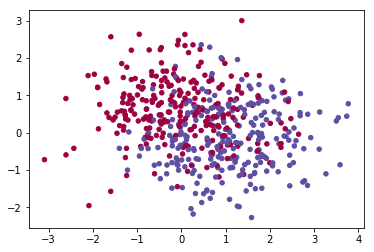

In [27]:
np.random.seed(2019)

# training set
X_train, Y_train = sklearn.datasets.make_moons(n_samples=512, noise=.8)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
# test set
X_test, Y_test = sklearn.datasets.make_moons(n_samples=256, noise=.8)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train.reshape(-1), s=20, cmap=plt.cm.Spectral);

We now initialise the model parameters $\theta \equiv (W^{[1]}, b^{[1]},\ldots, W^{[K]}, b^{[K]})$ to zeros. 

<font color='darkred'>**Exercise:**</font> Complete the following function using `np.zeros(shape)` where `shape` is the shape of the numpy array to be initialised with zeros.

In [34]:
def zeros_init(dims):
    """
    Arguments:
    dims -- array with number of units in each layer, size K
    
    Returns:
    params -- dictionary containing initialised model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised bias vector of shape (1, n_h1)
        ...
        Wk -- initialised weight matrix of shape (n_hk-1, n_hk)
        bk -- initialised bias vector of shape (1, n_hk)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised bias vector of shape (1, n_y)
    """
    
    K = len(dims) # number of layers
    params = {}    
    for k in range(1, K):
        ### INPUT YOUR CODE HERE ### (2 lines)
        params['W{}'.format(k)] = np.zeros([dims[k-1],dims[k]])
        params['b{}'.format(k)] = np.zeros([1,dims[k]])
        ### END OF YOUR CODE SEGMENT ###  
                                                    
        assert(params['W{}'.format(k)].shape == (dims[k - 1], dims[k]))
        assert(params['b{}'.format(k)].shape == (1, dims[k]))

    return params

In [35]:
# testing
np.random.seed(2019)
params = zeros_init([3,2,1])
print("W1 = {}".format(params["W1"]))
print("b1 = {} ".format(params["b1"]))
print("W2 = {}".format(params["W2"]))
print("b2 = {}".format(params["b2"]))

W1 = [[0. 0.]
 [0. 0.]
 [0. 0.]]
b1 = [[0. 0.]] 
W2 = [[0.]
 [0.]]
b2 = [[0.]]


***Expected Output:***<br>
`W1 = [[0. 0.]
 [0. 0.]
 [0. 0.]]
b1 = [[0. 0.]] 
W2 = [[0.]
 [0.]]
b2 = [[0.]]`

***

Evaluate the following cell to train the model on the dataset, initialising all parameters to zeros.

loss after 15000 epochs = 0.69
50.0% training acc.
50.0% test acc.


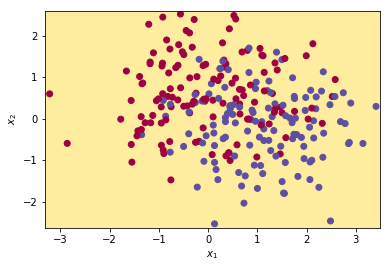

In [36]:
params, grads, loss_log = model_fit(X_train, Y_train, init='zeros')
print("loss after {} epochs = {:.2f}".format(len(loss_log) * 100, loss_log[-1]))

Y_hat_train = t5.model_predict(params, X_train)
Y_hat_test = t5.model_predict(params, X_test)
train_acc = 100 * (1 - np.mean(np.abs(Y_hat_train - Y_train)))
test_acc = 100 * (1 - np.mean(np.abs(Y_hat_test - Y_test)))
print("{:.1f}% training acc.".format(train_acc))
print("{:.1f}% test acc.".format(test_acc))

t5.plot_model(lambda x: t5.model_predict(params, x), X_test, Y_test.reshape(-1))

Our training failed and model did not learn anything, predicting 0 for every examples. By initialising all parameters to 0, the network units are learning the same thing and we may as well jsut keep a single unit and train a linear classifier like the logistic regression model. To get some meaninful prediction from our model,we must break the network symmetry and initialise our parameters from $\mathcal{N}(0,\sigma^2)$.

<font color='darkred'>**Exercise:**</font> Complete the following function, initialising weights $\sim\mathcal{N}(0,3)$ and setting biases to zeros. Use `np.random.randn(n1, n2)` to gerenate a random matrix of shape $(n_1,n_2)$ $\sim\mathcal{N}(0,1)$ (zero mean, unit variance).

In [39]:
def random_init(dims):
    """
    Arguments:
    dims -- array with number of units in each layer, size K
    
    Returns:
    params -- dictionary containing initialised model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised bias vector of shape (1, n_h1)
        ...
        Wk -- initialised weight matrix of shape (n_hk-1, n_hk)
        bk -- initialised bias vector of shape (1, n_hk)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised bias vector of shape (1, n_y)
    """
    
    K = len(dims) # number of layers

    params = {}    
    for k in range(1, K):
        ### INPUT YOUR CODE HERE ### (2 lines)
        params['W{}'.format(k)] = 3*(np.random.randn(dims[k-1],dims[k]))
        params['b{}'.format(k)] = np.zeros([1,dims[k]])
        ### END OF YOUR CODE SEGMENT ###  
                                                    
        assert(params['W{}'.format(k)].shape == (dims[k - 1], dims[k]))
        assert(params['b{}'.format(k)].shape == (1, dims[k]))

    return params

In [40]:
# testing
np.random.seed(2019)
params = random_init([3,2,1])
print("W1 = {}".format(params["W1"]))
print("b1 = {}".format(params["b1"]))
print("W2 = {}".format(params["W2"]))
print("b2 = {}".format(params["b2"]))

W1 = [[-0.653  2.464]
 [ 4.444  3.996]
 [-1.086  2.057]]
b1 = [[0. 0.]]
W2 = [[1.721]
 [0.863]]
b2 = [[0.]]


***Expected Output:***<br>
`W1 = [[-0.653  2.464]
 [ 4.444  3.996]
 [-1.086  2.057]]
b1 = [[0. 0.]]
W2 = [[1.721]
 [0.863]]
b2 = [[0.]]`

***

Evaluate the following cell to train the model on the same dataset, initialising parameters with "large" random numbers.

C:\Users\lenovo lappy\T5\t5utils.py:47: RuntimeWarning: divide by zero encountered in log
  loss = np.multiply(-np.log(A),Y) + np.multiply(-np.log(1 - A), 1 - Y)
C:\Users\lenovo lappy\T5\t5utils.py:47: RuntimeWarning: invalid value encountered in multiply
  loss = np.multiply(-np.log(A),Y) + np.multiply(-np.log(1 - A), 1 - Y)


loss after 15000 epochs = 0.45


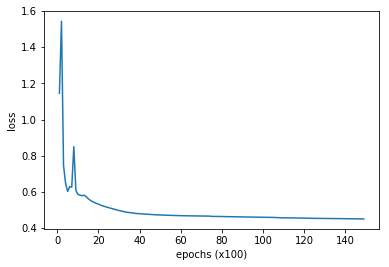

77.7% training acc.
69.9% test acc.


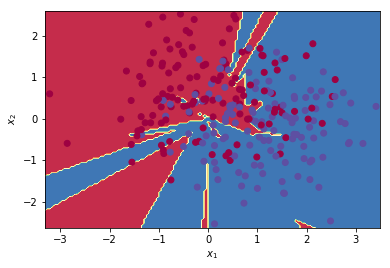

In [42]:
np.random.seed(2019)
params, grads, loss_log = model_fit(X_train, Y_train, init='random')
print("loss after {} epochs = {:.2f}".format(len(loss_log) * 100, loss_log[-1]))

plt.plot(loss_log)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.show()

Y_hat_train = t5.model_predict(params, X_train)
Y_hat_test = t5.model_predict(params, X_test)
train_acc = 100 * (1 - np.mean(np.abs(Y_hat_train - Y_train)))
test_acc = 100 * (1 - np.mean(np.abs(Y_hat_test - Y_test)))
print("{:.1f}% training acc.".format(train_acc))
print("{:.1f}% test acc.".format(test_acc))

%matplotlib inline
t5.plot_model(lambda x: t5.model_predict(params, x), X_test, Y_test.reshape(-1))

Performance is improved, however large random weights can result in a large input value to the final sigmoid activation. As a result, the network will have results close to 0 or 1 and the cross-entropy loss will be very large. This is known as poor initialisation and can lead to vanishing/exploding gradients. This also slows down the optimisation algorithm. Training the network longer may improve results.

A better strategy is to adapt the variance of the weights's distribution to the network toppology. This is known as the **Xavier initialisation** where the scaling factor is $\sqrt{{1}\over{n_{k-1}}}$ for $W^{[k]}$. A initialisation variation with improved performance for the ReLU activation was subsequently proposed by He et al. (2015) by scaling the Xavier initialisation: $\sqrt{{2}\over{n_{k-1}}}$.

<font color='darkred'>**Exercise:**</font> Complete the following function, initialising weights with He-scaling and setting biases to zeros.

In [49]:
def he_init(dims):
    """
    Arguments:
    dims -- array with number of units in each layer, size K
    
    Returns:
    params -- dictionary containing initialised model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised bias vector of shape (1, n_h1)
        ...
        Wk -- initialised weight matrix of shape (n_hk-1, n_hk)
        bk -- initialised bias vector of shape (1, n_hk)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised bias vector of shape (1, n_y)
    """
    K = len(dims) # number of layers

    params = {}    
    for k in range(1, K):
        ### INPUT YOUR CODE HERE ### (2 lines)
        params['W{}'.format(k)] = (1/np.sqrt(dims[k-1])) * np.random.randn(dims[k-1],dims[k])
        params['b{}'.format(k)] = np.zeros([1,dims[k]])
        ### END OF YOUR CODE SEGMENT ###  
                                                    
        assert(params['W{}'.format(k)].shape == (dims[k - 1], dims[k]))
        assert(params['b{}'.format(k)].shape == (1, dims[k]))

    return params

In [50]:
# testing
np.random.seed(2019)
params = he_init([3,2,1])
print("W1 = {}".format(params["W1"]))
print("b1 = {}".format(params["b1"]))
print("W2 = {}".format(params["W2"]))
print("b2 = {}".format(params["b2"]))

W1 = [[-0.126  0.474]
 [ 0.855  0.769]
 [-0.209  0.396]]
b1 = [[0. 0.]]
W2 = [[0.406]
 [0.203]]
b2 = [[0.]]


***Expected Output:***<br>
`W1 = [[-0.178  0.671]
 [ 1.209  1.087]
 [-0.295  0.56 ]]
b1 = [[0. 0.]] 
W2 = [[0.574]
 [0.288]]
b2 = [[0.]]`

***

Evaluate the following cell to train the model on the same dataset, initialising parameters with the He initialisation technique.

loss after 15000 epochs = 0.48


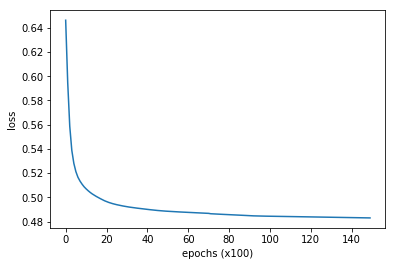

76.6% training acc.
74.6% test acc.


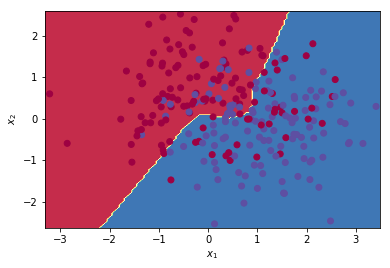

In [60]:
np.random.seed(2019)
params, grads, loss_log = model_fit(X_train, Y_train, init='he')
print("loss after {} epochs = {:.2f}".format(len(loss_log) * 100, loss_log[-1]))

plt.plot(loss_log)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.show()

Y_hat_train = t5.model_predict(params, X_train)
Y_hat_test = t5.model_predict(params, X_test)
train_acc = 100 * (1 - np.mean(np.abs(Y_hat_train - Y_train)))
test_acc = 100 * (1 - np.mean(np.abs(Y_hat_test - Y_test)))
print("{:.1f}% training acc.".format(train_acc))
print("{:.1f}% test acc.".format(test_acc))

t5.plot_model(lambda x: t5.model_predict(params, x), X_test, Y_test.reshape(-1))

We've improved our test accuracy by almost 5%. The **He initialisation** performs well and is a good choice in practive.

## C. Regularisation ##

Deep networks with large capacity can learn complex representations, however they are often prone to overfitting particularly if the supervised dataset is modest in size. Overfitting results in poor generalisation capabilities for the trained model. 

Evaluate the following cell to train a deep network with large capacity (this may take a few minutes to complete).

loss after 30000 epochs = 0.40


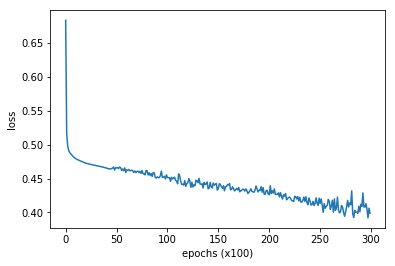

81.4% training acc.
69.1% test acc.


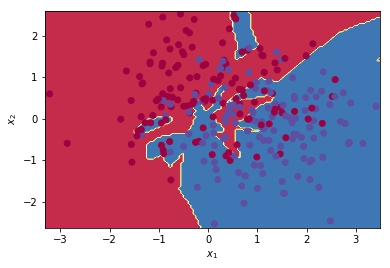

In [61]:
np.random.seed(2019)
params, grads, loss_log = model_fit(X_train, Y_train, n_h=[18, 9, 9], epochs=30000, learning_rate=0.1, verbose=False, init='he')
print("loss after {} epochs = {:.2f}".format(len(loss_log) * 100, loss_log[-1]))

plt.plot(loss_log)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.show()

Y_hat_train = t5.model_predict(params, X_train)
Y_hat_test = t5.model_predict(params, X_test)
train_acc = 100 * (1 - np.mean(np.abs(Y_hat_train - Y_train)))
test_acc = 100 * (1 - np.mean(np.abs(Y_hat_test - Y_test)))
print("{:.1f}% training acc.".format(train_acc))
print("{:.1f}% test acc.".format(test_acc))

t5.plot_model(lambda x: t5.model_predict(params, x), X_test, Y_test.reshape(-1)) 

The non-regularised model is overfitting the training set. It is fitting the dataset noise, leading to suboptimal generalisation.

### C.1 $L_2$ Regularisation ###

A common technique to reduce overfitting is called $L_2$ regularisation. It entails penalising the loss with the frobenius norm of the parameter weight matrices. If $\mathcal{L}$ is the cross-entropy loss, the $L_2$ regularised loss is given by:


$$\mathcal{L}_{reg} = \overbrace{-\frac{1}{n}\left(Y^T\, \log A^{[K]} + (1-Y)^T\,\log(1-A^{[K]})
\right)}^\text{cross-entropy loss} + \overbrace{\frac{1}{n}\frac{\lambda}{2}\left( \sum_k \left\|W^{[k]}\right\|^2_F \right)}^\text{$L_2$ regularisation} \tag{2}$$

$L_2$ regularisation is parametrised by the scalar $\lambda$. We must now modify our training function.

<font color='darkred'>**Exercise:**</font> Complete the following function, adding a $L_2$ regularisation term for all weights matrices to the cross-entropy loss computed during forward propagation. Note $\left\|W^{[k]}\right\|^2_F$ is simply computed in numpy with `np.sum(np.square(Wk))`

In [64]:
# Parameter optimisation using regularisation
def regularised_model_fit(X, Y, n_h, lambd, epochs, learning_rate, verbose=False, init="he"):
    """
    Optimise model parameters by performing gradient descent
    
    Arguments:
    n_h -- array with number of units in hidden layers, size K-1
    X -- n data samples  (n, n_x)
    Y -- groud truth label vector of size (n, n_y)
    lambd -- regularisation scalar
    epochs -- number of iteration updates through dataset
    learning_rate -- learning rate of the gradient descent
    init -- string, either 'random', 'zeros' or 'he'
    
    Returns:
    params -- dictionary containing model parameters
    grads -- dictionary with final gradients
    loss_log -- list of loss values for every 100 updates
    """
    
    # returns array [n_x, n_h[0], ..., n_h[K-1], n_y]
    dims = t5.model_config(X, Y, n_h)

    # create and initialise model parameters
    if init == 'random':
        params = random_init(dims)
    elif init == 'zeros':
        params = zeros_init(dims)
    elif init == 'he':
        params = he_init(dims)
    
    loss_log = []
    K = len(params) >> 1
    n = Y.shape[0]
    for i in range(epochs):
        A, loss, caches = t5.forward_prop(params, X, Y)
        
        for k in range(1, K):  
            ### INPUT YOUR CODE HERE ### (2 lines)
            Wk = params["W{}".format(k)]
            loss = loss + (1/n)*(lambd/2) * np.sum(np.square(Wk))
            ### END OF YOUR CODE SEGMENT ###  
        grads = regularised_back_prop(A, Y, caches, lambd)
        params = t5.update_params(params, grads, learning_rate)        
        
        # logs
        if i % 100 == 0:
            loss_log.append(np.asscalar(loss))
            if verbose:
                print("Loss after {} epochs: {:.3f}".format(i, loss))
     
    return params, grads, loss_log

Now that we have an extra term in the loss expression in equation (2), we must also update the backprop functions and recompute the gradients. Going through the differential computation of our network topology, we can quickly see that the regularisation term only affect the linear backprop with an extra component added to $dW^{[k]}$ given by $\frac{\partial }{\partial W^{[k]}} \left( \frac{1}{n} \frac{\lambda}{2} \left\|W^{[k]}\right\|^2_F\right ) = \frac{\lambda}{n} W^{[k]}$.


<font color='darkred'>**Exercise:**</font>  Implement the new linear backward propagation function to take into account regularisation.

In [65]:
def regularised_back_prop(AK, Y, caches, lambd):
    """
    Compute back-propagation gradients with regularisation
    
    Arguments:
    AK -- probability vector, final layer output, shape (1, n_y)
    Y -- ground truth output (n, n_y)
    caches -- array of layer cache, len=K
    lambd -- regularisation scalar

    Returns:
    grads -- dictionary containing your gradients with respect to all parameters
        dW1 -- weight gradient matrix of shape (n_x, n_h1)
        db1 -- bias gradient vector of shape (1, n_h1)
        ...
        dWK -- weight gradient matrix of shape (n_hK-1, n_y)
        dbK -- bias gradient vector of shape (1, n_y)
    """
    grads = {}
    K = len(caches)
    n = AK.shape[0]
    cache = caches[K - 1]
    
    ################### stable backprop for sigmoid output layer
    dZK = AK - Y
    grads["dW{}".format(K)], grads["db{}".format(K)], grads["dA{}".format(K)] = regularised_linear_back(dZK, cache['LINEAR'], lambd)

    for k in reversed(range(K - 1)):
        cache = caches[k]
        grads["dW{}".format(k + 1)], grads["db{}".format(k + 1)], grads["dA{}".format(k + 1)] = regularised_singlelayer_back(grads["dA{}".format(k + 2)], cache, 'ReLU', lambd)
    return grads

In [66]:
def regularised_singlelayer_back(dA, cache, non_linearity='ReLU', lambd=0):
    """
    Single layer backprop (linear + non-linearity) with regularisation

    Arguments:
    dA -- gradient of loss with respect to activation
    cache -- dictionary from forward propagation
        LINEAR -- dictionary from forward linear propagation 
        ACTIVATION -- dictionary from forward non-linearity propagation 
    non_linearity -- string ('ReLU' or 'Sigmoid') activation for layer
    lambd -- regularisation scalar

    Returns:
    dW -- gradient of loss with respect to current layer weights
    db -- gradient of loss with respect to current layer bias
    dA_prev -- gradient of loss with respect to activation of previous layer output
    """
        
    linear_cache = cache['LINEAR']
    activation_cache = cache['ACTIVATION']
    if non_linearity == 'Sigmoid':
        dZ = t5.sigmoid_back(dA, activation_cache)
    elif non_linearity == 'ReLU':
        dZ = t5.relu_back(dA, activation_cache)
    dW, db, dA_prev = regularised_linear_back(dZ, linear_cache, lambd)
    return dW, db, dA_prev

In [71]:
def regularised_linear_back(dZ, cache, lambd):
    """
    Linearity backprop

    Arguments:
    dZ -- gradient of loss with respect to current layer linear output
    cache -- dictionary from forward propagation
        W -- weight matrix
        b -- bias row vector
        A_prev -- previous layer activation input
    lambd -- regularisation scalar

    Returns:
    dW -- gradient of loss with respect to current layer weights
    db -- gradient of loss with respect to current layer bias
    dA_prev -- gradient of loss with respect to activation of previous layer output
    """
    dW, db, dA_prev = t5.linear_back(dZ, cache)
    ### INPUT YOUR CODE HERE ### (4 lines)
    A_prev = cache["A_prev"]
    W = cache["W"]
    n = A_prev.shape[0]
    dW = dW + (lambd/n)*W
    ### END OF YOUR CODE SEGMENT ###  
    return dW, db, dA_prev

In [72]:
# testing
AK, Y, caches = t5.back_prop_test()
grads = regularised_back_prop(AK, Y, caches, 0.7)
print("dW1.T = {}".format(grads['dW1'].T))
print("dW2.T = {}".format(grads['dW2'].T))

dW1.T = [[-1.121 -0.656  1.065 -0.421]
 [-1.08  -0.777  0.397 -0.781]
 [-0.208 -0.259  0.348 -0.077]]
dW2.T = [[-0.003 -0.66  -0.457]]


***Expected Output:***<br>
`dW1.T = [[-1.121 -0.656  1.065 -0.421]
 [-1.08  -0.777  0.397 -0.781]
 [-0.208 -0.259  0.348 -0.077]]
dW2.T = [[-0.003 -0.66  -0.457]]`

***

Evaluate the cell below and observe the effect of the $L_2$ regularisation on the model training setting the regularisation hyperparameter scalar to 1.0.

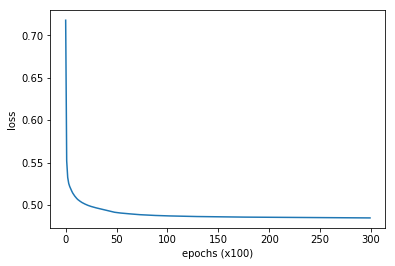

loss after 30000 epochs = 0.48
77.0% training acc.
72.3% test acc.


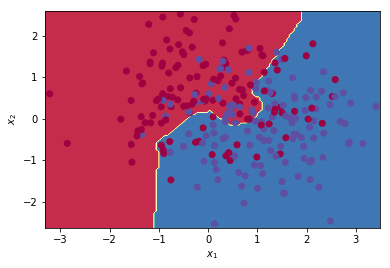

In [73]:
np.random.seed(2019)
params, grads, loss_log = regularised_model_fit(X_train, Y_train, lambd=1.0, n_h=[18, 9, 9], epochs=30000, learning_rate=0.1, verbose=False, init='he')

plt.plot(loss_log)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.show()

print("loss after {} epochs = {:.2f}".format(len(loss_log) *100, loss_log[-1]))
Y_hat_train = t5.model_predict(params, X_train)
Y_hat_test = t5.model_predict(params, X_test)
train_acc = 100 * (1 - np.mean(np.abs(Y_hat_train - Y_train)))
test_acc = 100 * (1 - np.mean(np.abs(Y_hat_test - Y_test)))
print("{:.1f}% training acc.".format(train_acc))
print("{:.1f}% test acc.".format(test_acc))

t5.plot_model(lambda x: t5.model_predict(params, x), X_test, Y_test.reshape(-1))

$L_2$ regularisation enforce small weights on our trained model parameters by penalising the square values of the weights in the regularised loss function (large weight values become prohibitive in loss).

With the same network topology, we now have a model that generalise better on the test dataset, resolving the overfitting issue observed previously. $L_2$ regularisation requires to select a value for hyper-parameter $\lambda$. This is generally carried out on a separate validation set. $L_2$ regularisation has for effect to smooth the decision boundaries, however setting $\lambda$ to a really large value can result in a high bias model.

### C.2 Dropout ###

Another regularisation technique widely employed in deep learning is called dropout. It consists in randomly shutting down some neurons in each iteration (epoch or minibatch) of the training process.

The idea behind drop-out is to train a different model at each iteration, only using a subset of the layers' units. 
As a result, neuron units become less sensitive to the activation of specific units from the previous layer (other units can be shut down at any time). Dropout modifies the model at each training iteration.

Dropout is specified at each layer level by setting a dropout rate (probability) in the range of (0,1) that corresponds to the percentage of units randomly turned off during each training iteration. This means both forward and back propagation must be modified to support dropout.


<font color='darkred'>**Exercise:**</font> Modify the feedforward function, adding dropout to the hidden layer activations. For $k\in \{1,\ldots,K-1\}$ (no dropout for output layer), let $p_k=$`dropouts[k-1]`

- create a random matrix $D^{[k]}$ (same shape as $A^{[k]}$ activations), drawn from the uniform distribution (range 0 to 1)
- set entries of $D^{[k]}$ to 0 with probability in $p_k$ and to 1 with probability $1-p_k$ 
- shut down neuron activation using dropout random matrix i.e. set $A^{[k]} \leftarrow A^{[k]} \odot D^{[k]}$
- scale all $A^{[k]}$ activation entries by $\frac{1}{1-p_k}$ so that to keep the same expected value for the loss (this is known as the inverted dropout)
- add the dropout matrix $D^{[k]}$ to the cache for backprop

In [91]:
def forward_prop_with_dropout(params, X, Y=None, dropouts=None):
    """
    Compute the layer activations and loss if needed

    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    X -- n data samples, shape = (n, n_x)
    Y -- optional argument, ground truth label, column vector of shape (n, n_y)
    dropouts -- optional argument, list of dropout rates from A1 to AK-1

    Returns:
    A -- final layer output (activation value) 
    loss -- cross-entropy loss or NaN if Y=None
    caches -- array of caches for the K layers
    """
        
    caches = []
    K = len(params) >> 1
    A = X
    for k in range(1, K):
        A_prev = A
        W = params['W{}'.format(k)]
        b = params['b{}'.format(k)]
        A, cache = t5.singlelayer_fwd(W, b, A_prev, non_linearity='ReLU')

        if dropouts is not None:
            dropout_rate = dropouts[k - 1]
            ### INPUT YOUR CODE HERE ### (5 lines)
            D = np.random.rand(A.shape[0],A.shape[1])    # initialize dropout matrix D = np.random.rand(..., ...)
            #print(D)
            #print(dropout_rate)
            D = np.where(D<dropout_rate,0.0,1.0)    # convert entries of D to 0 or 1
            A = A*D    # shut down neuron units of A
            A = A/(1-dropout_rate)    # scale value of active neurons units
            #print(A)
            cache['DROPOUT'] = D     # add dropout matrix to cache
            ### END OF YOUR CODE SEGMENT ###
        
        caches.append(cache)
        
    A_prev = A
    W = params['W{}'.format(K)]
    b = params['b{}'.format(K)]
    A, cache = t5.singlelayer_fwd(W, b, A_prev, non_linearity='Sigmoid')
    
    caches.append(cache)
    loss = float('nan')
    if Y is not None:
        n = Y.shape[0]
        loss = np.multiply(-np.log(A),Y) + np.multiply(-np.log(1 - A), 1 - Y)
        loss = np.squeeze(np.nansum(loss) / n)
    return A, loss, caches

In [96]:
# testing
X, Y, params, dropouts = t5.forward_prop_with_dropout_test()
A, loss, caches = forward_prop_with_dropout(params, X, Y, dropouts)
for i, cache in enumerate(caches[0:len(dropouts)]):
        print("Layer {} dropout = {:.2f} (target {:.2f})".format(i + 1, 1 - np.mean(cache['DROPOUT']), dropouts[i]))

Layer 1 dropout = 0.53 (target 0.50)
Layer 2 dropout = 0.43 (target 0.50)
Layer 3 dropout = 0.28 (target 0.30)


***Expected Output:***<br>
`Layer 1 dropout = 0.53 (target 0.50)
Layer 2 dropout = 0.43 (target 0.50)
Layer 3 dropout = 0.28 (target 0.30)`

***

<font color='darkred'>**Exercise:**</font> Implement the dropout backprop function using the random  dropout matrix $D^{[k]}$ computed during forward propagation and stored in the cache. Remember that we have no dropout on the output layer.

- set $\frac{\partial \mathcal{L}}{\partial A^{[k]}}=0$ for the neurons shutdown during forward propagation
- scale $\frac{\partial \mathcal{L}}{\partial A^{[k]}}$ by same $\frac{1}{1-p_k}$ to match the forward propagation scaling of the neuron activations

In [103]:
def back_prop_with_dropout(AK, Y, caches, dropouts=None):
    """
    Compute back-propagation gradients with dropout
    
    Arguments:
    AK -- probability vector, final layer output, shape (1, n_y)
    Y -- ground truth output (n, n_y)
    caches -- array of layer cache, len=K
    dropouts -- optional argument, list of dropout rates (K-1)
    
    Returns:
    grads -- dictionary containing your gradients with respect to all parameters
        dW1 -- weight gradient matrix of shape (n_x, n_h1)
        db1 -- bias gradient vector of shape (1, n_h1)
        ...
        dWK -- weight gradient matrix of shape (n_hK-1, n_y)
        dbK -- bias gradient vector of shape (1, n_y)
    """
    if dropouts is not None:
        dropout_cache = {}
        # retrieve dropout cache
        for i, cache in enumerate(caches[0:len(dropouts)]): # no dropout on output layer
            dropout_cache["D{}".format(i + 1)] = cache['DROPOUT']
        
    grads = {}
    K = len(caches)
    n = AK.shape[0]
    cache = caches[K - 1]
    # stable backprop for sigmoid output layer
    dZK = AK - Y
    grads["dW{}".format(K)], grads["db{}".format(K)], grads["dA{}".format(K)] = t5.linear_back(dZK, cache['LINEAR'])
    
    for k in reversed(range(K - 1)):
        cache = caches[k]
        dA = grads["dA{}".format(k + 2)]
                
        # Hidden layer dropout
        if dropouts is not None:
            dropout_rate = dropouts[k]
            ### INPUT YOUR CODE HERE ### (2 lines)
            dA = dA*dropout_cache["D{}".format(k+1)]  # shut down the same units as during forward propagation
            dA = dA/(1-dropout_rate)    # scale va1ue of active neuron units
            ### END OF YOUR CODE SEGMENT ###
        
        grads["dW{}".format(k + 1)], grads["db{}".format(k + 1)], grads["dA{}".format(k + 1)] = t5.singlelayer_back(dA, cache, 'ReLU')
    return grads

In [104]:
# testing
X, Y, params, dropouts = t5.backprop_with_dropout_test()
A, loss, caches = forward_prop_with_dropout(params, X, Y, dropouts)
grads = back_prop_with_dropout(A, Y, caches, dropouts)
print("dW1.T = {}".format(grads['dW1'].T))
print("db1 = {}".format(grads['db1']))
print("dA1 = {}".format(grads['dA1']))
print("dW2.T = {}".format(grads['dW2'].T))
print("db2 = {}".format(grads['db2']))
print("dA2 = {}".format(grads['dA2']))

dW1.T = [[ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 2.915 11.002 19.838 17.837  4.846  9.182  7.684  3.853]]
db1 = [[0.    0.    1.674]]
dA1 = [[22.629  6.897 35.788  6.744 42.924  6.35   7.172  6.037]]
dW2.T = [[  0.      0.      0.   ]
 [  0.      0.    446.819]]
db2 = [[0.    0.475]]
dA2 = [[0.31  1.321 0.837]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


***Expected Output:***<br>
`dW1.T = [[ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 2.915 11.002 19.838 17.837  4.846  9.182  7.684  3.853]]
db1 = [[0.    0.    1.674]]
dA1 = [[22.629  6.897 35.788  6.744 42.924  6.35   7.172  6.037]]
dW2.T = [[  0.      0.      0.   ]
 [  0.      0.    446.819]]
db2 = [[0.    0.475]]
dA2 = [[0.31  1.321 0.837]]`

***

Evaluate the following cells and observe the droput effect on the model training.

In [93]:
# Parameter optimisation using regularisation
def dropout_model_fit(X, Y, n_h, dropouts, epochs, learning_rate, verbose=False, init="he"):
    """
    Optimise model parameters by performing gradient descent
    
    Arguments:
    X -- n data samples  (n, n_x)
    Y -- groud truth label vector of size (n, n_y)
    n_h -- array with number of units in hidden layers, size K-1
    dropouts -- optional argument, list of dropout rates (K-1)
    epochs -- number of iteration updates through dataset
    learning_rate -- learning rate of the gradient descent
    init -- string, either 'random', 'zeros' or 'he'
    
    Returns:
    params -- dictionary containing model parameters
    grads -- dictionary with final gradients
    loss_log -- list of loss values for every 100 updates
    """
    
    # model topology, array [n_x, n_h[0], ..., n_h[K-1], n_y]
    dims = t5.model_config(X, Y, n_h)

    # create and initialise model parameters
    if init == 'random':
        params = random_init(dims)
    elif init == 'zeros':
        params = zeros_init(dims)
    elif init == 'he':
        params = he_init(dims)
    
    loss_log = []
    K = len(params) >> 1
    n = Y.shape[0]
    for i in range(epochs):
        A, loss, caches = forward_prop_with_dropout(params, X, Y, dropouts)
        grads = back_prop_with_dropout(A, Y, caches, dropouts)
        params = t5.update_params(params, grads, learning_rate)        
        
        # logs
        if i % 100 == 0:
            loss_log.append(np.asscalar(loss))
            if verbose:
                print("Loss after {} epochs: {:.3f}".format(i, loss))
     
    return params, grads, loss_log

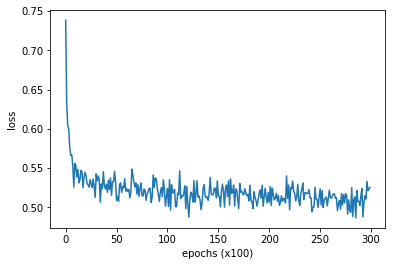

loss after 30000 epochs = 0.53
77.3% training acc.
73.0% test acc.


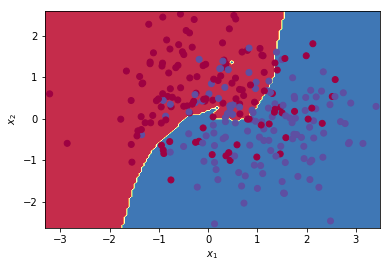

In [105]:
np.random.seed(2019)
params, grads, loss_log = dropout_model_fit(X_train, Y_train, dropouts=[0.5, 0.3, 0.3], n_h=[18, 9, 9], epochs=30000, learning_rate=0.1, verbose=False, init='he')

plt.plot(loss_log)
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.show()

print("loss after {} epochs = {:.2f}".format(len(loss_log) *100, loss_log[-1]))
Y_hat_train = t5.model_predict(params, X_train)
Y_hat_test = t5.model_predict(params, X_test)
train_acc = 100 * (1 - np.mean(np.abs(Y_hat_train - Y_train)))
test_acc = 100 * (1 - np.mean(np.abs(Y_hat_test - Y_test)))
print("{:.1f}% training acc.".format(train_acc))
print("{:.1f}% test acc.".format(test_acc))

t5.plot_model(lambda x: t5.model_predict(params, x), X_test, Y_test.reshape(-1))

Overfitting is reduced and test accuracy improves with dropout. Dropout is a regularisation technique that works well in practice. 

**Note that a common mistake is to use dropout both in training and testing** when it should only be applied to forward and backward propagation in training. During training, the dropout activations must be scaled according to the dropout rates to ensure the expected value for the loss remains the same. The fact that we ignore dropout units means that the performance on the training set will be lower, however testing accuracy will improve.

Both $L_2$ regularisation and dropout are effective regularisation techniques useful to combat overfitting, and keeping model parameters to small values.